# 네이버 영화리뷰 감성분석
------------

## 데이터 준비와 확인

* 네이버 영화의 댓글을 모아 구성된 데이터셋을 다운로드한다.

```python
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

In [12]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [13]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
 
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [14]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [16]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


### 적절한 최대 문장 길이 지정

In [17]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [18]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='post', # 혹은 'pre'
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델구성 및 validation set 구성

### RNN

In [19]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 1-D Convolution Neural Network(1-D CNN)

In [22]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### GlobalMaxPooling1D()

In [23]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


* 검증셋(validation set)

In [19]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 훈련 개시

### RNN

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1701 - accuracy: 0.9378 - val_loss: 0.5088 - val_accuracy: 0.8274
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1660 - accuracy: 0.9390 - val_loss: 0.5217 - val_accuracy: 0.8263
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1624 - accuracy: 0.9412 - val_loss: 0.5303 - val_accuracy: 0.8277
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1594 - accuracy: 0.9427 - val_loss: 0.5411 - val_accuracy: 0.8228
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1564 - accuracy: 0.9440 - val_loss: 0.5533 - val_accuracy: 0.8221
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1538 - accuracy: 0.9452 - val_loss: 0.5649 - val_accuracy: 0.8222
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1515 - accuracy: 0.9464 - val_loss: 0.5765 - val_accuracy: 0.8210
Epoch 

### 1-D Convolution Neural Network(1-D CNN)

In [36]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.1460 - accuracy: 0.9583 - val_loss: 0.6889 - val_accuracy: 0.8343
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1422 - accuracy: 0.9601 - val_loss: 0.7016 - val_accuracy: 0.8371
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1396 - accuracy: 0.9611 - val_loss: 0.7008 - val_accuracy: 0.8342
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1394 - accuracy: 0.9609 - val_loss: 0.7315 - val_accuracy: 0.8360
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1377 - accuracy: 0.9616 - val_loss: 0.7764 - val_accuracy: 0.8349
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1370 - accuracy: 0.9618 - val_loss: 0.7624 - val_accuracy: 0.8335
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1365 - accuracy: 0.9620 - val_loss: 0.7458 - val_accuracy: 0.8339
Epoch 

### GlobalMaxPooling1D()

In [37]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1475 - accuracy: 0.9468 - val_loss: 0.5172 - val_accuracy: 0.8300
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1414 - accuracy: 0.9502 - val_loss: 0.5371 - val_accuracy: 0.8271
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1373 - accuracy: 0.9523 - val_loss: 0.5508 - val_accuracy: 0.8267
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1332 - accuracy: 0.9538 - val_loss: 0.5667 - val_accuracy: 0.8247
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1293 - accuracy: 0.9556 - val_loss: 0.5789 - val_accuracy: 0.8252
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1255 - accuracy: 0.9568 - val_loss: 0.5926 - val_accuracy: 0.8256
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1217 - accuracy: 0.9587 - val_loss: 0.6095 - val_accuracy: 0.8226
Epoch 

## Loss, Accuracy 그래프 시각화

In [20]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'history' is not defined

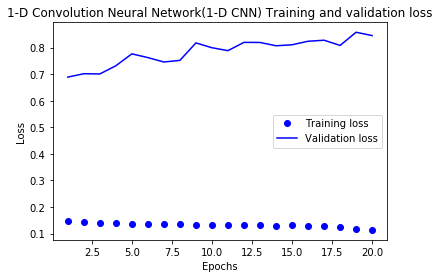

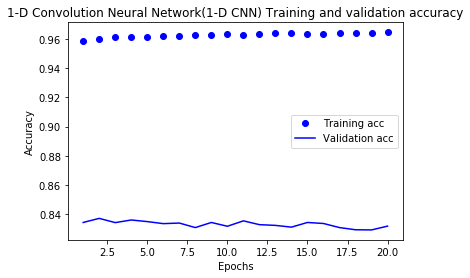

In [41]:
import matplotlib.pyplot as plt

history_dict2 = history2.history
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1-D Convolution Neural Network(1-D CNN) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('1-D Convolution Neural Network(1-D CNN) Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

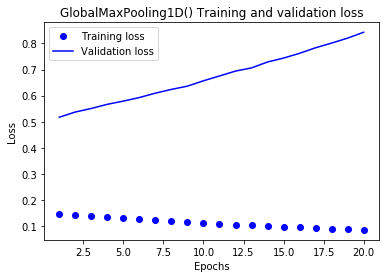

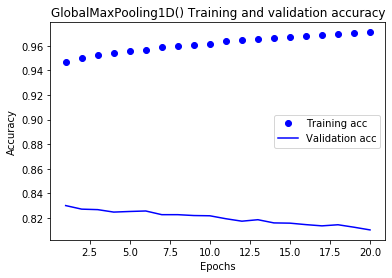

In [42]:
import matplotlib.pyplot as plt

history_dict3 = history3.history
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D() Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D() Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [45]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("love")

(10000, 16)


[('life', 0.9331067204475403),
 ('곱씹', 0.9282602667808533),
 ('집시', 0.9140900373458862),
 ('괜춘', 0.9087306261062622),
 ('스틱', 0.9053727388381958),
 ('캡틴', 0.9046480655670166),
 ('해져요', 0.9045622944831848),
 ('메이퀸', 0.9014118909835815),
 ('♥♥♥♥', 0.8909986019134521),
 ('사실감', 0.8887094259262085)]

## 한국어 Word2Vec 임베딩 활용하여 성능개선

In [21]:
import os

from gensim.models.word2vec import Word2Vec
han2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
han2vec = Word2Vec.load(han2vec_path)
han2vec.similar_by_word("사랑")

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in han2vec:
        embedding_matrix[i] = han2vec[index_to_word[i]]

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.MaxPooling1D(5))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.GlobalMaxPooling1D())
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [24]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 14s 54ms/step - loss: 0.5850 - accuracy: 0.6826 - val_loss: 0.4436 - val_accuracy: 0.7987
Epoch 2/20
266/266 [==============================] - 10s 36ms/step - loss: 0.3913 - accuracy: 0.8256 - val_loss: 0.3654 - val_accuracy: 0.8383
Epoch 3/20
266/266 [==============================] - 8s 31ms/step - loss: 0.3303 - accuracy: 0.8585 - val_loss: 0.3493 - val_accuracy: 0.8442
Epoch 4/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2994 - accuracy: 0.8750 - val_loss: 0.3438 - val_accuracy: 0.8494
Epoch 5/20
266/266 [==============================] - 9s 32ms/step - loss: 0.2747 - accuracy: 0.8872 - val_loss: 0.3471 - val_accuracy: 0.8505
Epoch 6/20
266/266 [==============================] - 11s 41ms/step - loss: 0.2525 - accuracy: 0.8984 - val_loss: 0.3529 - val_accuracy: 0.8478
Epoch 7/20
266/266 [==============================] - 8s 30ms/step - loss: 0.2345 - accuracy: 0.9064 - val_loss: 0.3571 - val_accuracy: 0.8

In [25]:
# 테스트셋을 통한 모델 평가
results = model4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.7859 - accuracy: 0.8276
[0.7858893871307373, 0.8276339173316956]


## 회고

상당히 어려웠고 아직도 이해가 잘 안된다. 그래도 정확도는 나쁘지 않은것 같은데 깊이 공부를 해봐야 할 듯 하다.      

내일 글쓰기 시간에 정리하는걸 한번 도전해봐야겠다.   

정말 더럽게도 MeCab 설치하는거 가지고 2시간은 걸렸고, 그냥 노드 하는데만도 엄청 걸렸다. 그리고 마지막으로는 한국어 Word2Vec 돌리는데 아까 Aiffel 1기 분이 말씀하셨던 OOM 떠서 그냥 노트북을 재부팅 시켰는데 확실히 epoch 속도가 엄청 느려졌다. OOM 해결법도 알아봐야겠다.